In [23]:
from pathlib import Path

import os
import numpy as np
import torch
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

### Let's load the scan itself


In [24]:
# make sure you have copied the example data to data/example

subject_root = Path('data/example/S88111')
assert subject_root.exists()

path_scan = subject_root / 'T1toMNIlin.nii.gz'
assert path_scan.exists()

# load the scan to a numpy array
scan = nib.load(path_scan).get_fdata()
print(scan.shape)

(182, 218, 182)


#### Now let's visualize it

We will look at the middle slice of the coronal axis


<class 'numpy.ndarray'>


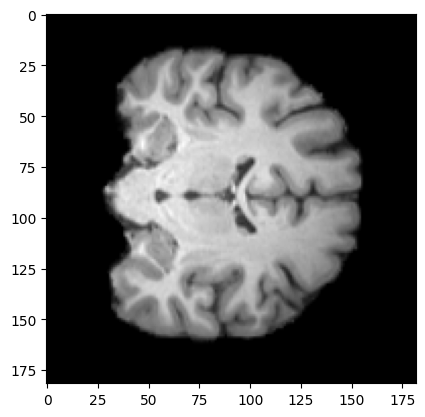

In [28]:
print(type(scan))
plt.imshow(scan[:, scan.shape[1] // 2], cmap='gray')
plt.show()
plt.close()

### Let's load the corresponding segmentation mask


In [30]:
path_mask = (subject_root / 'synthseg_7_3_2' /
             'T1toMNIlin_synthseg.nii.gz').resolve()
assert path_mask.exists(), f"File not found: {path_mask}"

# Load the mask file and get its data
mask = nib.load(path_mask).get_fdata()

# Print the shape of the mask data
print("Mask shape:", mask.shape)

Mask shape: (182, 218, 182)


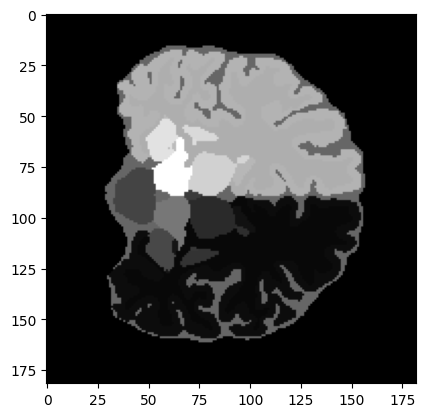

In [33]:
plt.imshow(mask[:, mask.shape[1] // 2], cmap='gray')
plt.show()
plt.close()

It looks different - instead of continuous values, each voxel has an integer value telling us which class (Region of Interest) it belongs to.


In [34]:
np.unique(mask)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 24., 26., 28., 41., 42., 43., 44., 46., 47., 49.,
       50., 51., 52., 53., 54., 58., 60.])

In [ ]:
labels_str = '''
 0        background
 2        left cerebral white matter
 3        left cerebral cortex
 4        left lateral ventricle
 5        left inferior lateral ventricle
 7        left cerebellum white matter
 8        left cerebellum cortex
10        left thalamus
11        left caudate
12        left putamen
13        left pallidum
14        3rd ventricle
15        4th ventricle
16        brain-stem
17        left hippocampus
18        left amygdala
26        left accumbens area
28        left ventral DC
41        right cerebral white matter
42        right cerebral cortex
43        right lateral ventricle
44        right inferior lateral ventricle
46        right cerebellum white matter
47        right cerebellum cortex
49        right thalamus
50        right caudate
51        right putamen
52        right pallidum
53        right hippocampus
54        right amygdala
58        right accumbens area
60        right ventral DC'''

labels_dict = {}
for line in labels_str[1:].split('\n'):
    labels_dict[int(line[:2])] = line[10:]

In [ ]:
# Ensure `scan` is a float type and normalize to [-1, 1]
scan = scan.astype(float)
scan = (scan - scan.min()) / (scan.max() - scan.min())  # Normalize to [0, 1]
scan = scan * 2 - 1  # Scale to [-1, 1]

# Convert to PyTorch tensor
scan_tensor = torch.tensor(scan, dtype=torch.float32)

# Print tensor shape to confirm
print("Scan tensor shape:", scan_tensor.shape)

### Transforming data into Pytorch tensors


In [ ]:
import torch

# we will encode the scans as float tensors
# first, let's normalize the values to [-1, 1]
scan = (scan - scan.min()) / scan.max() * 2 - 1
scan
scan_tensor = torch.FloatTensor(scan)

# My Dataset

In [1]:
import pandas as pd

metadata = pd.read_csv(
    '/dhc/home/arman.beykmohammadi/AMLS/ml-seminar-brain-mri-dementia-ivae/df.csv')
print("initial metadata shape:", metadata.shape)

null_columns = []
for column in metadata.columns:
    if metadata[column].isnull().any():
        null_columns.append(column)
        print(f"NaN rows from \"{column}\" column:",
              metadata[column].isnull().sum())
print("Columns including NaN values:", null_columns)

# removing the downloaded column
metadata = metadata.drop(columns='Downloaded')
print("Columns after droping NaN Column:", list(metadata.columns))

initial metadata shape: (12791, 22)
NaN rows from "Downloaded" column: 12791
NaN rows from "mmse" column: 249
Columns including NaN values: ['Downloaded', 'mmse']
Columns after droping NaN Column: ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'RID', 'CDGLOBAL', 'CDGLOBAL_MAX', 'path', 'MAGSTRENGTH', 'IMAGEUID', 'mmse', 'hippo', 'ventricles', 'CI']


In [79]:
# Removing mmse's null rows and droping "Downloaded" column to make the metadata clean
print("Shape before droping NaN values", metadata.shape)
metadata_cleaned = metadata.dropna(subset=['mmse'])
print("Shape after droping NaN values:", metadata_cleaned.shape)
print("Number of removed rows because of NaN in \"mmse\" column:",
      metadata.shape[0] - metadata_cleaned.shape[0], '\n')

Shape before droping NaN values (12791, 21)
Shape after droping NaN values: (12542, 21)
Number of removed rows because of NaN in "mmse" column: 249 



In [80]:
non_important_columns = ['Image Data ID', 'Visit', 'Modality',
                         'Description', 'Type', 'Acq Date', 'Format', 'RID', 'IMAGEUID', 'CI']
for i, column in enumerate(non_important_columns):
    print(f"{i+1}. {column}:", metadata_cleaned[column].unique().shape)

1. Image Data ID: (12542,)
2. Visit: (28,)
3. Modality: (1,)
4. Description: (77,)
5. Type: (1,)
6. Acq Date: (2816,)
7. Format: (1,)
8. RID: (1655,)
9. IMAGEUID: (12542,)
10. CI: (2,)


In [81]:
print("Columns before droping the non-important columns:",
      list(metadata_cleaned.columns))
print("Shape before droping the non-important columns:", metadata_cleaned.shape)

metadata_final = metadata_cleaned.drop(columns=non_important_columns)

print("Columns after droping the non-important columns:",
      list(metadata_final.columns))
print("Shape after droping the non-important columns:", metadata_final.shape)

print("Non-important columns:", non_important_columns)

Columns before droping the non-important columns: ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'RID', 'CDGLOBAL', 'CDGLOBAL_MAX', 'path', 'MAGSTRENGTH', 'IMAGEUID', 'mmse', 'hippo', 'ventricles', 'CI']
Shape before droping the non-important columns: (12542, 21)
Columns after droping the non-important columns: ['Subject', 'Group', 'Sex', 'Age', 'CDGLOBAL', 'CDGLOBAL_MAX', 'path', 'MAGSTRENGTH', 'mmse', 'hippo', 'ventricles']
Shape after droping the non-important columns: (12542, 11)
Non-important columns: ['Image Data ID', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'RID', 'IMAGEUID', 'CI']


In [88]:
metadata = metadata_final[['Subject', 'Group', 'Sex', 'Age']]

In [ ]:
metadata.

In [83]:
path.shape

(12791,)

In [15]:
metadata = metadata[['Subject', 'Group', 'Sex', 'Age']]
Subjects = metadata['Subject'].to_numpy()
metadata = metadata[metadata['Group'].isin(['CN', 'AD'])]
metadata['Group'] = metadata['Group'].map({'CN': 0, 'AD': 1})
metadata['Sex'] = metadata['Sex'].map({'M': 0, 'F': 1})
metadata = metadata.to_numpy()[:, 1:]

In [6]:
metadata

array([[0, 0, 74],
       [0, 1, 78],
       [0, 1, 78],
       ...,
       [1, 1, 87],
       [1, 1, 62],
       [0, 1, 64]], dtype=object)

In [1]:
import torch
import torch.utils.data as torch_data
import nibabel as nib
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np


class MRIDataset(torch_data.Dataset):
    def __init__(self, path_to_csv):
        super().__init__()

        # Loading metadata
        self.metadata = pd.read_csv(
            path_to_csv)[['path', 'Subject', 'Group', 'Sex', 'Age']]

        # Selecting subjects with CN and AD
        self.metadata = self.metadata[self.metadata['Group'].isin([
                                                                  'CN', 'AD'])]
        # Maping the values in Group and Sex to 0 and 1
        self.metadata['Group'] = self.metadata['Group'].map({'CN': 0, 'AD': 1})
        self.metadata['Sex'] = self.metadata['Sex'].map({'M': 0, 'F': 1})

        self.path = self.metadata['path'].to_numpy()
        self.Subjects = self.metadata['Subject'].to_numpy()
        self.metadata = self.metadata.to_numpy()[:, 2:].astype(int)

        self.n_samples = self.path.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        path_subject = self.path[idx]
        assert Path(path_subject).exists(), f"File not found: {path_subject}"
        scan = nib.load(path_subject).get_fdata()
        scan = scan[:, scan.shape[1] // 2]
        scan = (scan - scan.min()) / scan.max() * 2 - 1
        scan_tensor = torch.tensor(scan, dtype=torch.float64)
        labels_tensor = torch.tensor(self.metadata[idx], dtype=torch.int)

        return scan_tensor, labels_tensor

In [2]:
test = MRIDataset(
    "/dhc/home/arman.beykmohammadi/AMLS/ml-seminar-brain-mri-dementia-ivae/df.csv")

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True)

# For creating wand project based on the date and time of the run
time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Start cross-validation on the training set
for i, (train_idx, val_idx) in enumerate(sgkf.split(np.zeros(dataset.n_samples), dataset.metadata[:, 0], dataset.Subjects)):
    print('--------------------')
    print(f'Starting fold {i+1}...')

In [3]:
np.unique(test.Subjects).shape

(884,)

In [4]:
test.metadata.shape

(5318, 3)

In [17]:
test.metadata[:, 0]

array([0, 0, 0, ..., 1, 1, 0])

In [10]:
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(np.zeros(test.n_samples), test.metadata[:, 0], test.Subjects)):
    print(f"Fold {i}:")

    print(
        f"  Train: index={train_index.shape}, group={np.unique(test.Subjects[train_index]).shape}, status={np.unique(test.metadata[train_index,0], return_counts=True)}")

    print(
        f"  Test:  index={test_index.shape}, group={np.unique(test.Subjects[test_index]).shape}, status={np.unique(test.metadata[test_index,0], return_counts=True)}")

Fold 0:
  Train: index=(4718,), group=(795,), status=(array([0, 1]), array([3399, 1319]))
  Test:  index=(600,), group=(89,), status=(array([0, 1]), array([435, 165]))
Fold 1:
  Train: index=(4747,), group=(795,), status=(array([0, 1]), array([3342, 1405]))
  Test:  index=(571,), group=(89,), status=(array([0, 1]), array([492,  79]))
Fold 2:
  Train: index=(4840,), group=(797,), status=(array([0, 1]), array([3501, 1339]))
  Test:  index=(478,), group=(87,), status=(array([0, 1]), array([333, 145]))
Fold 3:
  Train: index=(4814,), group=(796,), status=(array([0, 1]), array([3486, 1328]))
  Test:  index=(504,), group=(88,), status=(array([0, 1]), array([348, 156]))
Fold 4:
  Train: index=(4773,), group=(795,), status=(array([0, 1]), array([3486, 1287]))
  Test:  index=(545,), group=(89,), status=(array([0, 1]), array([348, 197]))
Fold 5:
  Train: index=(4763,), group=(795,), status=(array([0, 1]), array([3423, 1340]))
  Test:  index=(555,), group=(89,), status=(array([0, 1]), array([411,

In [ ]:
logo.get_n_splits(np.zeros(test.n_samples),
                  np.zeros(test.n_samples), test.Subjects)

884

In [8]:
import numpy as np


def kl_divergence(mean, log_var):
    """
    Compute the KL divergence between the approximate posterior q(z|x) and the prior p(z).

    Parameters:
    - mean (numpy.ndarray): The mean vector of the approximate posterior (batch_size, latent_dim).
    - log_var (numpy.ndarray): The log variance vector of the approximate posterior (batch_size, latent_dim).

    Returns:
    - numpy.ndarray: KL divergence for each sample in the batch (batch_size,).
    """
    # Calculate KL divergence for each latent dimension
    kl_per_dim = -0.5 * (1 + log_var - mean**2 - np.exp(log_var))
    # Sum over all latent dimensions for each sample
    kl_divergence = np.sum(kl_per_dim, axis=1)
    return kl_divergence


# Example mean and log variance vectors for a batch of 3 samples and latent_dim of 2
mean = np.array([[0.0, 0.0], [0.5, -0.5], [1.0, 1.0]])
log_var = np.array([[0.0, 0.0], [0.1, -0.1], [0.5, -0.5]])

# Compute KL divergence
kl_values = kl_divergence(mean, log_var)

print("KL Divergence per sample:", kl_values)
kl_values

KL Divergence per sample: [0.         0.25500417 1.12762597]


array([0.        , 0.25500417, 1.12762597])

In [130]:
scan_tensor, labels = test[4]

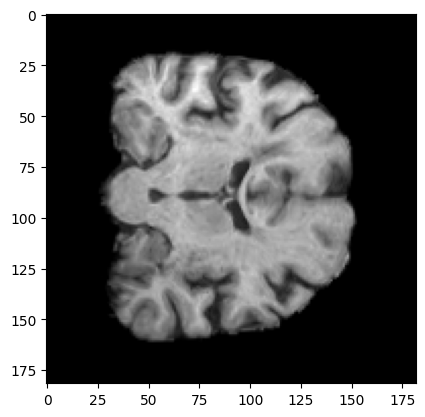

In [131]:
plt.imshow(scan_tensor, cmap='gray')
plt.show()
plt.close()

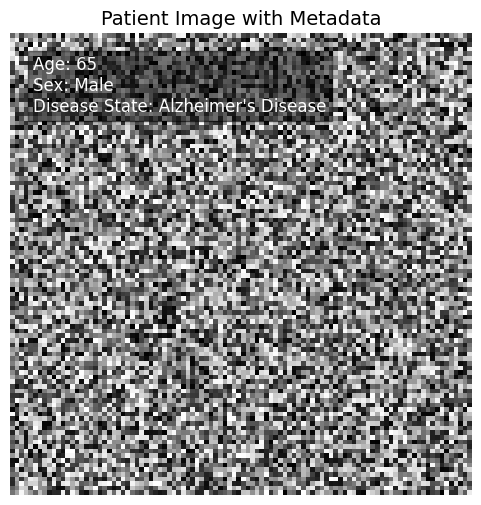

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example Image (NumPy array)
image = np.random.rand(100, 100)  # Replace this with your image array

# Metadata
metadata = {
    "Age": 65,
    "Sex": "Male",
    "Disease State": "Alzheimer's Disease"
}

# Plotting the Image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')  # Display the image (use cmap if grayscale)

# Add Metadata as Text
text = f"Age: {metadata['Age']}\nSex: {metadata['Sex']}\nDisease State: {metadata['Disease State']}"
plt.text(0.05, 0.95, text, fontsize=12, color='white', ha='left', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='black', alpha=0.5))

# Additional Plot Configurations
plt.axis('off')  # Turn off axis ticks and labels
plt.title("Patient Image with Metadata", fontsize=14)

# Show the Plot
plt.show()